<a href="https://colab.research.google.com/github/KishuSInha/SENTIMENT-ANALYSIS/blob/main/SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -U tensorflow scikit-learn nltk matplotlib seaborn wordcloud textblob yellowbrick

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import warnings

In [3]:
# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

In [4]:
# Upload the Restaurant_Reviews.tsv file
uploaded = files.upload()

Saving Restaurant_Reviews .tsv to Restaurant_Reviews .tsv


In [6]:
# Load the dataset (fixed filename issue)
df = pd.read_csv('Restaurant_Reviews .tsv', delimiter="\t")
print(df.head(20))

                                               Review  Liked
0                            Wow... Loved this place.      1
1                                  Crust is not good.      0
2           Not tasty and the texture was just nasty.      0
3   Stopped by during the late May bank holiday of...      1
4   The selection on the menu was great and so wer...      1
5      Now I am getting angry and I want my damn pho.      0
6               Honeslty it didn't taste THAT fresh.)      0
7   The potatoes were like rubber and you could te...      0
8                           The fries were great too.      1
9                                      A great touch.      1
10                           Service was very prompt.      1
11                                 Would not go back.      0
12  The cashier had no care what so ever on what I...      0
13  I tried the Cape Cod ravoli, chicken, with cra...      1
14  I was disgusted because I was pretty sure that...      0
15  I was shocked becaus

In [7]:
# Creating the copy of dataset.
df =df.copy()


In [8]:
# Dataset First Look.

df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [9]:
# Dataset Rows & Columns count
print(f' We have total {df.shape[0]} rows and {df.shape[1]} columns.')

 We have total 1000 rows and 2 columns.


In [10]:
# Dataset Info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [11]:
# Dataset Duplicate Value Count.
df.duplicated(keep='last').sum()

4

In [12]:
# Resting Index.
df.reset_index(inplace=True)

In [13]:
# Checking duplicate reviews in the 'Review' column
df['Review'].duplicated().sum()

4

In [14]:
# Missing values in 'Review' column
df['Review'].isnull().sum()

0

In [17]:
# Checking for Null values.
df[df['Review'].isnull()].head()
print(df.columns)

Index(['index', 'Review', 'Liked'], dtype='object')


In [18]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')  # Ensure punkt tokenizer is downloaded
nltk.download('punkt_tab')  # If punkt_tab specifically is the missing resource

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
# Initialize the stemmer and stopwords
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [20]:
# Function to clean and preprocess the text
def clean_text(text):
    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text
    words = nltk.word_tokenize(text)  # This will now use the 'punkt' resource
    # Remove stopwords and stem words
    words = [ps.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

In [21]:
# Apply the cleaning function to the review column
df['cleaned_review'] = df['Review'].apply(clean_text)

In [22]:
# Map sentiment labels from 1/0 to 'Positive'/'Negative'
df['Sentiment'] = df['Liked'].map({1: 'Positive', 0: 'Negative'})

In [23]:
# Define X and y
X = df['cleaned_review']
y = df['Liked']  # 1 for Positive, 0 for Negative

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# TF-IDF Vectorization (optional, as you're using Tokenizer)
#TEST TRAIN SPLIT METHOD
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [26]:
# Parameters for padding and tokenization
max_words =2000  # Vocabulary size
max_len = 150     # Max length of input sequences

In [29]:
# Tokenization and padding
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train.tolist())  # Convert to list for tokenizer
X_train_seq = tokenizer.texts_to_sequences(X_train.tolist())
X_test_seq = tokenizer.texts_to_sequences(X_test.tolist())
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [30]:
# Build the Bidrectional model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, return_sequences=True))  # LSTM layer
model.add(Dropout(0.3))  # Regular dropout
model.add(LSTM(50))      # Another LSTM layer
model.add(Dropout(0.3))  # Regular dropout
model.add(Dense(1, activation='sigmoid'))  # Output layer


In [31]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [32]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',mode ='min', patience=5, restore_best_weights=True,verbose=1)


In [53]:
# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping]  # Added early stopping
)


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step - accuracy: 0.9856 - loss: 0.0529 - val_accuracy: 0.7900 - val_loss: 0.7611
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 564ms/step - accuracy: 0.9853 - loss: 0.0505 - val_accuracy: 0.7750 - val_loss: 0.8349
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 893ms/step - accuracy: 0.9805 - loss: 0.0502 - val_accuracy: 0.7600 - val_loss: 0.8151
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.9853 - loss: 0.0403 - val_accuracy: 0.7600 - val_loss: 0.8221
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 576ms/step - accuracy: 0.9831 - loss: 0.0439 - val_accuracy: 0.7650 - val_loss: 0.8800
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [54]:
# Evaluate the model
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        96
           1       0.79      0.81      0.80       104

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200

Confusion Matrix:
[[74 22]
 [20 84]]


WORD CLOUD FOR POSITIVE REVIEWS:



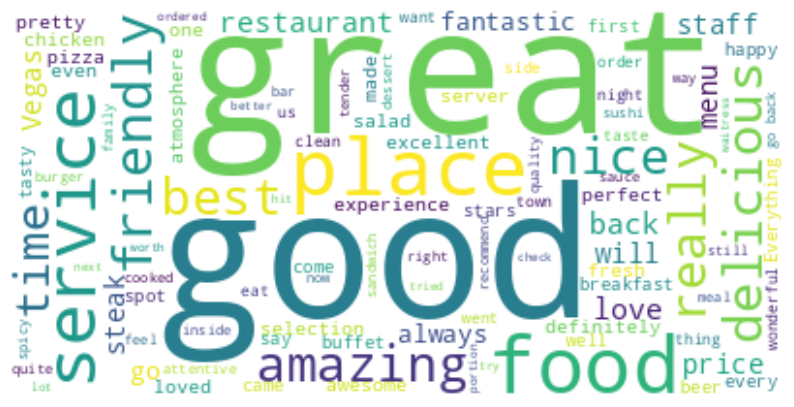

In [55]:
# Word cloud for positive reviews.
print("WORD CLOUD FOR POSITIVE REVIEWS:")
print()
pos_rev =df[df['Liked'] == 1]
long_string = ','.join(list(pos_rev['Review'].values))
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue').generate(long_string)
# Display the word cloud
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.show()

WORD CLOUD FOR NEGATIVE REVIEWS: 



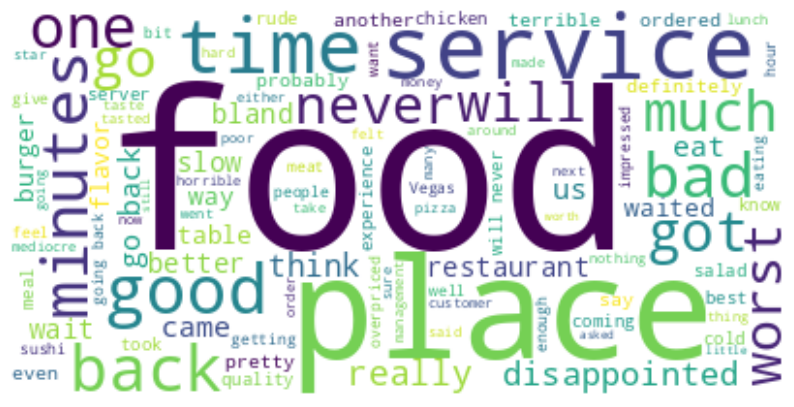

In [37]:
#Word cloud for negative reviews
print("WORD CLOUD FOR NEGATIVE REVIEWS: ")
print()
neg_rev = df[df['Sentiment'] == 'Negative']  # or use df[df['Liked'] == 0] for numeric labels
# Generate a long string from the negative reviews for word cloud
long_string = ','.join(list(neg_rev['Review'].values))
long_string
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue').generate(long_string)
# Display the word cloud
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.show()

In [39]:
# Apply TF-IDF vectorization to convert text reviews into numerical features
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_review'])

In [40]:
# Create a list of inertia scores for different numbers of clusters
scores = [KMeans(n_clusters=i+2, random_state=11).fit(X_tfidf).inertia_
          for i in range(8)]

LINE PLOT FOR INERTIA SCORES VERSUS NUMBER OF CLUSTERS :



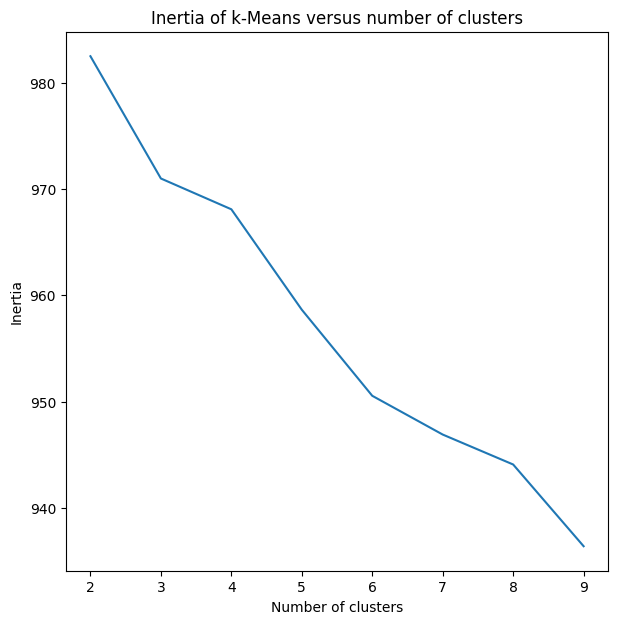

In [56]:
# Create a line plot of inertia scores versus number of clusters
print("LINE PLOT FOR INERTIA SCORES VERSUS NUMBER OF CLUSTERS :")
print()
plt.figure(figsize=(7,7))
sns.lineplot(x=np.arange(2, 10), y=scores)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia of k-Means versus number of clusters')
plt.show()

TRAINING AND VALIDATION ACCURACY: 



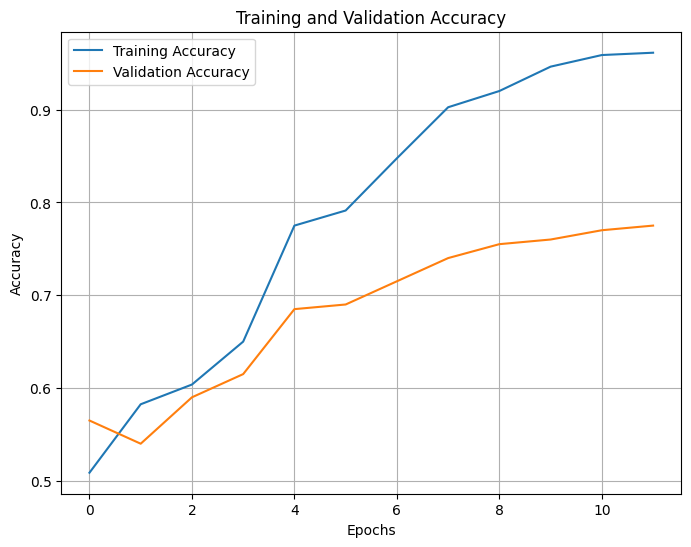

In [59]:
# Plot training & validation accuracy
print("TRAINING AND VALIDATION ACCURACY: ")
print()
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
